Star battle game
================

## Rules of the game

This game is played on a grid that is separated into different zones.
In each area there must be $n$ stars, in each column there must be $n$ stars and in each row.
In addition, two stars can not touch each other even if they are in different zones and diagonally.
Depending on the size of the grid, $n$ is either 1, 2, 3 or another value.


We have some rules:
 1. There are $n$ stars in each column.
 2. There are $n$ stars in each row.
 3. There are $n$ stars in each region.
 4. Two stars do not touch each other, not even diagonally.


## Exemple:
![](img/exemple.png "Grille vide") ![](img/exemple_filled.png "Grille pleine")

## Entry format

The entry format of a grid will be a text file with the following format:

 - every line of the file is a row of the grid, each number is a zone identification.
 - the number of zone need to began with a 1 and be separated by a space.

Here is the exemple of file representing the previous grid:

```
1 1 1 1 2 2 2 2 2
1 1 1 1 3 3 2 2 4
5 1 1 1 3 3 3 4 4
5 5 5 5 6 6 6 4 4
5 5 6 6 6 6 6 4 4
5 7 6 6 6 6 6 6 4
7 7 7 7 7 8 8 8 4
7 7 7 7 7 8 8 8 8
9 9 9 9 8 8 8 8 8
```

### Imports

In [1]:
from __future__ import annotations

import functools
import os
import random
from itertools import combinations
from typing import List, NoReturn
import warnings


from IPython.display import Image as IPImage, Markdown as IPMarkdown, display, clear_output, HTML
from PIL import Image, ImageDraw
from pysat.solvers import Glucose3

### Types

In [2]:
variable = int
list_of_variable = List[variable]
clause = List[variable]
set_of_clauses = List[clause]

### CNF generator

First to formalize rules 1, 2 and 3 we need to define à CNF represent $n$ variable true among $m$.

Let note $P_k(E)$ the set of k combinations of $E$, the  CNF represent $n$ variable true among a set $E$ of $m$ variables will be defined by:

$$\bigwedge\limits_{i \in [\![0, m]\!]\ | i \ne n } \left( \bigwedge\limits_{S \in P_i(E)}  \left( \bigvee_{var \in S} \lnot var \right) \lor \left( \bigvee_{var \in E\setminus S} var \right) \right) $$

In [3]:
def get_CNF_n_true_among(values: list_of_variable, n: int) -> set_of_clauses:
    """
    Returns the CNF equivalent to two true variables from the list provided in parameter

    Parameters
    ----------
    values : int
        List of logic variables
    n : int
        Number of true variables

    """
    if n < 1:
        raise ValueError(f"The number of true variables must be at least 1.")
    if len(values) < n:
        raise ValueError(f"The size of the list must be at least {n}.")

    close: set_of_clauses = []

    for j in range(len(values) + 1):
        if j != n:
            for cmb in combinations(values, j):
                close.append([-k if k in cmb else k for k in values])
    return close

To formalize rules 4 we need to define à CNF represent no variables true among neighbors of a given variable.

Let define $V$ the set of neighbors of a given variable $var$, the CNF represent no variables true among $V$ will be defined by:

$$\bigwedge\limits_{n \in V} \lnot n \lor \lnot var $$


In [4]:
def get_CNF_no_true_among_neighbor(var: variable, neighbor: list_of_variable) -> set_of_clauses:
    """
    Returns the CNF equivalent to no true variable among the neighbor of the variable provided in parameter

    Parameters
    ----------
    var : list_of_variable
        Initial variable
    neighbor : list_of_variable
        List of neighbor of the initial variable

    """
    if var in neighbor:
        raise ValueError(f"The variable {var} is in the list of neighbor.")

    return [[-var, -var_neighbor] for var_neighbor in neighbor]

### DIMAC and SAT functions

To represent our grid, we will use simple variables, they will be numbered from 1 to the width of the grid in square.
For example the variables for a 5 by 5 grid will be :

```
1 2 3 4 5
6 7 8 9 10
11 12 13 14 15
16 17 18 19 20
21 22 23 24 25
```

In [5]:
def write_DIMAC(path: str, clauses_list: set_of_clauses, nb_of_variable: int) -> NoReturn:
    """
    Write the clause in DIMAC format in the file given in parameter

    Parameters
    ----------
    path : str
        Path of the file where the clause will be written
    clauses_list : set_of_clauses
        Clauses to write in DIMAC format
    nb_of_variable : int
        Number of variable of the grid
    """

    with open(path, 'w') as f:
        f.write(f"p cnf {nb_of_variable} {len(clauses_list)}\n")
        for cls in clauses_list:
            for var in cls:
                f.write(f"{var} ")
            f.write("0\n")


def read_DIMAC(path: str) -> (set_of_clauses, int):
    """
    Read the DIMAC file and return the clauses

    Parameters
    ----------
    path : str
        Path of the file to read

    Returns
    -------
    set_of_clauses
        Clauses of the DIMAC file
    int
        Number of variable of set_of_clauses
    """
    with open(path, 'r') as f:
        lines = f.readlines()

    maxvalue: int = 0
    cnf: set_of_clauses = []

    for line in lines:
        if line.startswith('c'):  # skip comments
            continue
        elif line.startswith('p'):  # get the number of variable
            maxvalue = int(line.split()[2])
        else:  # get the clauses
            cnf += list(map(int, line.split()[:-1]))

    return cnf, maxvalue


def convert_NSAT_to_3SAT(cnf: set_of_clauses, maxvalue: int) -> (set_of_clauses, int):
    """
    Convert NSAT clauses to 3SAT clauses

    Parameters
    ----------
    cnf : set_of_clauses
        Clauses of the NSAT file
    maxvalue : int
        Number of variable of the NSAT file

    Returns
    -------
    set_of_clauses
        Clauses of the 3SAT file
    int
        Number of variable of the 3SAT file
    """
    new_cnf: set_of_clauses = []
    for cls in cnf:
        if len(cls) == 1:  # if the clause is of length 1, it is a unit clause
            maxvalue += 2
            new_cnf.extend([[x1 := cls[0], y1 := maxvalue, y2 := maxvalue - 1],
                            [x1, y1, -y2],
                            [x1, -y1, y2],
                            [x1, -y1, -y2]])
        elif len(cls) == 2:  # if the clause is of length 2, it is a binary clause
            maxvalue += 1
            new_cnf.extend([[x1 := cls[0], x2 := cls[1], y1 := maxvalue],
                            [x1, x2, -y1]])
        else:
            while len(cls) > 3:
                new_clause: cls = []
                for i in range(0, len(cls), 2):
                    if i + 1 < len(cls):
                        maxvalue += 1
                        new_cnf.append([cls[i], cls[i + 1], -maxvalue])
                        new_clause.append(maxvalue)
                    else:
                        new_clause.append(cls[i])
                cls = new_clause
            new_cnf.append(cls)

    return new_cnf, maxvalue


def get_unsat_clause(cnf: set_of_clauses, assignment: list_of_variable) -> set_of_clauses:
    """
    Get the unsat clause of the CNF given in parameter

    Parameters
    ----------
    cnf : set_of_clauses
        CNF to check
    assignment : list_of_variable
        Assignment to check

    Returns
    -------
    set_of_clauses
        Unsat clause of the CNF
    """
    unsat_clause: set_of_clauses = []
    for cls in cnf:
        is_true: bool = False
        for var in cls:
            if var in assignment:
                is_true = True
                break
        if not is_true:
            unsat_clause.append(cls)
    return unsat_clause


def nb_sat_clause(cnf: set_of_clauses, assignment: list_of_variable) -> int:
    """
    Get the number of sat clause of the CNF given in parameter

    Parameters
    ----------
    cnf : set_of_clauses
        CNF to check
    assignment : list_of_variable
        Assignment to check

    Returns
    -------
    int
        Number of sat clause of the CNF
    """
    ret: int = 0
    for cls in cnf:
        for var in cls:
            if var in assignment:
                ret += 1
                break
    return ret


def sat_solver(cnf: set_of_clauses, nb_of_clauses: int, maxvalue: int) -> list_of_variable | None:
    """
    Solve the SAT problem

    Parameters
    ----------
    cnf : set_of_clauses
        Clauses of the SAT problem
    nb_of_clauses : int
        Number of clauses of the SAT problem
    maxvalue : int
        Number of variable of the SAT problem

    Returns
    -------
    list_of_variable:
        Solution of the SAT problem or None if no solution found
    """

    v: list_of_variable = [i if random.random() < 0.5 else -i for i in range(1, maxvalue + 1)]
    i: int = 0
    n = nb_of_clauses ** 2

    while i < n:
        unsat = get_unsat_clause(cnf, v)
        if len(unsat) == 0: return v
        c = random.choice(unsat)

        if random.random() < 0.2:  # Flip a random variable
            x = random.choice(c)
        else:  # Flip the variable with the most impact in unsat clause
            x: variable = c[0]
            max_sat: int = 0
            for var in c:
                v[abs(var) - 1] *= -1
                if max_sat < (m := nb_sat_clause(cnf, v)):
                    x = var
                    max_sat = m
                v[abs(var) - 1] *= -1
        v[abs(x) - 1] *= -1
        i += 1

    return None


### Starbattle specific functions and IO

To solve the problem we will just have to read the grid and to build the CNF:
 - for each row add the CNF of $n$ true among the variables in the row ;
 - for each column add the CNF of $n$ true among the variables of the column ;
 - for each field add the CNF of $n$ true among the variables of the field ;
 - for each variable, add the CNF of false variable if one of the neighbors is true.

In [6]:
class StarbattleGrille:
    def __init__(self, path: str):
        """
        Read the grid of Starbattle game file given in parameter
        """
        with open(path, "r") as f:  # open the file and read it
            self.data = f.readlines()

        self.grid: List[List[str]] = [line.strip().split(" ") for line in self.data]
        self.dim: int = len(self.grid[0])  # get the number of columns in the grid

    def get_line(self, line_number: int) -> list_of_variable:
        """
        Return all variables of the line given in parameter
        """
        valeur_deb = (line_number - 1) * self.dim + 1

        return list(range(valeur_deb, valeur_deb + self.dim))

    def get_column(self, col_number: int) -> list_of_variable:
        """
        Return all variables of the column given in parameter
        """
        return list(range(col_number, self.dim ** 2 + 1, self.dim))

    def get_zone(self, zone_number: int) -> list_of_variable:
        """
        Return all variables of the zone given in parameter
        """
        zone: list_of_variable = []
        k: int = 1
        for line in self.grid:
            for elt in line:
                if int(elt) == zone_number:
                    zone.append(k)
                k += 1
        return zone

    def get_neighbor(self, var: int) -> list_of_variable:
        """
        Return all variables of the neighbor of the variable given in parameter
        """

        l: list_of_variable = [var + 1, var - 1, var - self.dim, var + self.dim, var - self.dim - 1,
                               var - self.dim + 1, var + self.dim - 1, var + self.dim + 1]

        if var % self.dim == 1:  # if the variable is in the first column
            l.remove(var - 1)
            l.remove(var + self.dim - 1)
            l.remove(var - self.dim - 1)

        elif var % self.dim == 0:  # if the variable is in the last column
            l.remove(var + 1)
            l.remove(var + self.dim + 1)
            l.remove(var - self.dim + 1)

        if var <= self.dim:  # if the variable is in the first line
            if var % self.dim != 1:
                l.remove(var - self.dim - 1)
            if var % self.dim != 0:
                l.remove(var - self.dim + 1)
            l.remove(var - self.dim)

        elif var > self.dim * (self.dim - 1):  # if the variable is in the last line
            if var % self.dim != 1:
                l.remove(var + self.dim - 1)
            if var % self.dim != 0:
                l.remove(var + self.dim + 1)
            l.remove(var + self.dim)

        return l

    def get_dimension(self) -> int:
        """
        Return the number of lines/column/zone in the grid
        """
        return self.dim

    def draw_image(self, path: str, star_pos=None) -> NoReturn:
        """
        Write an image of the grid in the file given in parameter
        path: str
            path of the file where the image will be written
        star_pos: list_of_variable
            list of the position of the stars in the grid
        """
        if star_pos is None:
            star_pos = []

        img = Image.new("RGB", (self.dim * 50 + 1, self.dim * 50 + 1), "white")
        draw = ImageDraw.Draw(img)

        # draw the grid
        for i in range(1, self.dim):
            draw.line((0, i * 50, self.dim * 50, i * 50), fill="black")
            draw.line((i * 50, 0, i * 50, self.dim * 50), fill="black")
        draw.rectangle((0, 0, self.dim * 50, self.dim * 50), outline="red", width=3)

        # draw the border
        for x in range(self.dim):
            for y in range(1, self.dim):
                if self.grid[x][y - 1] != self.grid[x][y]:
                    draw.line((y * 50, (x + 1) * 50, y * 50, x * 50), fill="red", width=3)
                if self.grid[y - 1][x] != self.grid[y][x]:
                    draw.line(((x + 1) * 50, y * 50, x * 50, y * 50), fill="red", width=3)

        # draw the stars
        if star_pos:
            for i in range(self.dim):
                for j in range(1, self.dim + 1):
                    if i * self.dim + j in star_pos:
                        draw.ellipse(((j - 1) * 50 + 10, i * 50 + 10, j * 50 - 10, (i + 1) * 50 - 10), fill="yellow")
        img.save(path)


@functools.lru_cache(typed=True)
def get_battle_star_clauses(grid: StarbattleGrille, n: int) -> set_of_clauses:
    """
    Returns the CNF equivalent to the Starbattle game

    Parameters
    ----------
    grid : Lire_grille
        Grid of the Starbattle game
    n : int
        Number of star by line/column/zone

    """
    ret: set_of_clauses = []

    for i in range(1, grid.get_dimension() + 1):
        ret.extend(get_CNF_n_true_among(grid.get_zone(i), n))
        ret.extend(get_CNF_n_true_among(grid.get_line(i), n))
        ret.extend(get_CNF_n_true_among(grid.get_column(i), n))

    for var in range(1, grid.get_dimension() ** 2 + 1):
        ret.extend(get_CNF_no_true_among_neighbor(var, grid.get_neighbor(var)))

    return ret


def solver(path: str, n: int, convert_to_3sat: bool = False, local: bool = False, write_dimac: bool = False) -> list_of_variable:
    """
    Run the SAT solver on the clauses of the Starbattle game and return the result

    Parameters
    ----------
    path : str
        Path of the file where the clause is written
    n : int
        Number of star by line/column/zone
    convert_to_3sat: bool
        If True, convert the clauses to 3SAT clauses
    local: bool
        If True, run the solver locally
    write_dimac: bool
        If True, write the clauses in DIMACS format

    Returns
    -------
    list_of_variable
        List of the true variable of the grid (if the grid is solved)
    """

    grid: StarbattleGrille = StarbattleGrille(path)
    grid.draw_image(f"{path.split('.')[-2] + '.png'}")
    title = IPMarkdown("## Starbattle Solver\n#### Original grid\n")
    img = IPImage(f"{path.split('.')[-2] + '.png'}")
    display(title, img)

    starbattle_clauses: set_of_clauses = get_battle_star_clauses(grid, n)
    maxvalue = grid.get_dimension() ** 2

    if convert_to_3sat:  # Convert the clauses to 3SAT clauses if needed
        starbattle_clauses, maxvalue = convert_NSAT_to_3SAT(starbattle_clauses, maxvalue)

    if write_dimac:  # Write the clauses in DIMACS format
        write_DIMAC(f"{path.split('.')[-2] + '.dimacs'}", starbattle_clauses, maxvalue)


    if not local:
        g = Glucose3(starbattle_clauses, maxvalue)
        g.solve()
        result: List[variable] = g.get_model()

        if result is None:
            warnings.warn("The grid is UNSAT", UserWarning)

    else:
        result: List[variable] = sat_solver(starbattle_clauses, len(starbattle_clauses), maxvalue)

        if result is None:
            warnings.warn("The SAT solver returned a UNDEF problem", UserWarning)

    if result is not None:
        data = [var for item in result if abs(var := int(item)) <= grid.get_dimension() ** 2 and var > 0]
    else:
        data = []

    grid.draw_image(f"{path.split('.')[-2] + '_solved.png'}", data)

    if data:
        title = IPMarkdown(f"## Starbattle Solver\n#### Solved grid (generated with {len(starbattle_clauses)} clauses)\n")
    else:
        title = IPMarkdown(f"## Starbattle Solver\n#### The grid is UNSAT or UNDEF with ({len(starbattle_clauses)} clauses)\n")

    img = IPImage(f"{path.split('.')[-2] + '_solved.png'}")
    clear_output()
    display(title, img)

    return data

### No let's test the solver

To execute the solver, you need to use the function
```python3
solver(path: str, n: int, convert_to_3sat: bool, local: bool)
```
with the following parameters:
    - `path`: path of the file where the grid is written
    - `n`: number of star by line/column/zone
    - `convert_to_3sat`: if True, convert the clauses to 3SAT clauses
    - `local`: if True, run the solver locally else use python-sat

## With the grid of the first exemple using python-sat :

## Starbattle Solver
#### Solved grid (generated with 34264 clauses)


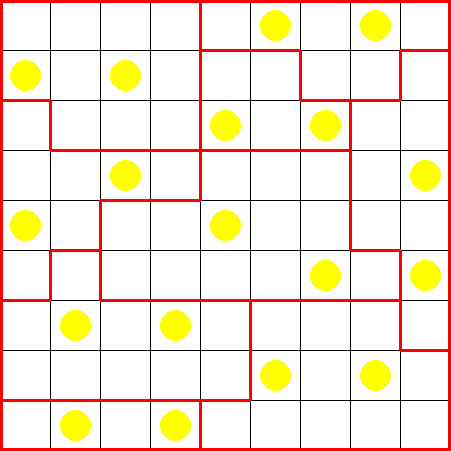

CPU times: total: 78.1 ms
Wall time: 233 ms


[6, 8, 10, 12, 23, 25, 30, 36, 37, 41, 52, 54, 56, 58, 69, 71, 74, 76]

In [7]:
%%time
solver("Exemples/test1.txt", 2)

## ...using python-sat and 3-SAT conversion :

## Starbattle Solver
#### Solved grid (generated with 354713 clauses)


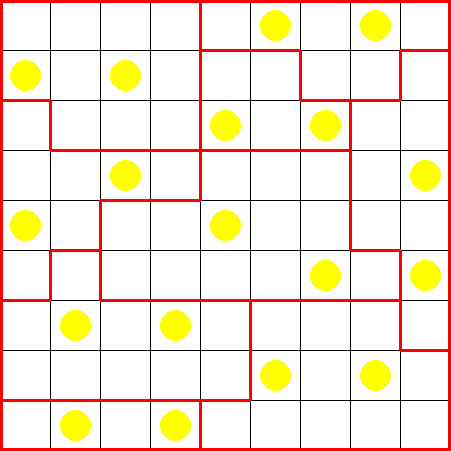

CPU times: total: 1.41 s
Wall time: 2.77 s


[6, 8, 10, 12, 23, 25, 30, 36, 37, 41, 52, 54, 56, 58, 69, 71, 74, 76]

In [8]:
%%time
solver("Exemples/test1.txt", 2, convert_to_3sat=True)

## Starbattle Solver
#### Solved grid (generated with 64614 clauses)


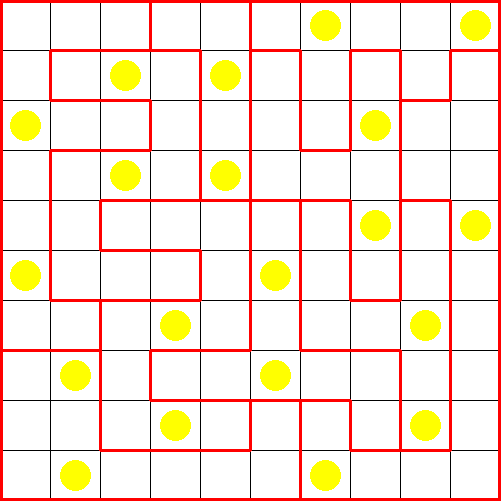

CPU times: total: 859 ms
Wall time: 1.36 s


[7, 10, 13, 15, 21, 28, 33, 35, 48, 50, 51, 56, 64, 69, 72, 76, 84, 89, 92, 97]

In [9]:
%%time
solver("Exemples/test7.txt", 2, write_dimac=True)

## Starbattle Solver
#### Solved grid (generated with 721059 clauses)


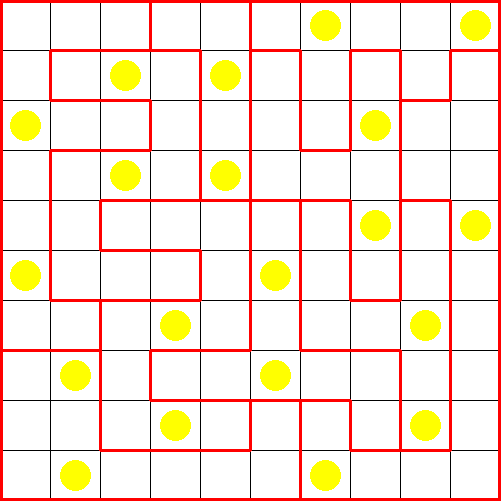

CPU times: total: 4.81 s
Wall time: 8.12 s


[7, 10, 13, 15, 21, 28, 33, 35, 48, 50, 51, 56, 64, 69, 72, 76, 84, 89, 92, 97]

In [10]:
%%time
solver("Exemples/test7.txt", 2, write_dimac=True, convert_to_3sat=True)

## With the other grid with one star by line/column/zone :

## Starbattle Solver
#### Solved grid (generated with 985 clauses)


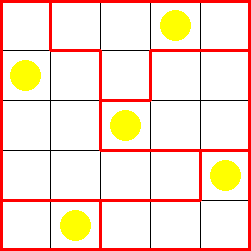

CPU times: total: 0 ns
Wall time: 32.7 ms


[4, 6, 13, 20, 22]

In [11]:
%%time
solver("Exemples/test3.txt", 1)

## ...using local SAT solver :

## Starbattle Solver
#### Solved grid (generated with 985 clauses)


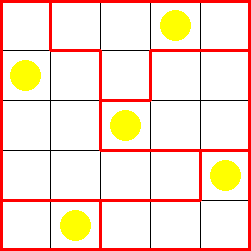

CPU times: total: 828 ms
Wall time: 1.28 s


[4, 6, 13, 20, 22]

In [12]:
%%time
solver("Exemples/test3.txt", 1, local=True)

## ...trying to solve a grid with two star by line/column/zone with python-sat :

## Starbattle Solver
#### The grid is UNSAT or UNDEF with (897 clauses)


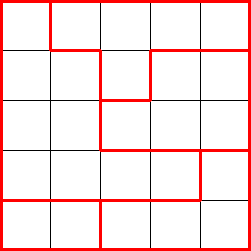

CPU times: total: 0 ns
Wall time: 39.6 ms


[]

In [13]:
%%time
solver("Exemples/test3.txt", 2)

## ...trying to solve a grid with two star by line/column/zone with python-sat and 3-SAT conversion :

## Starbattle Solver
#### The grid is UNSAT or UNDEF with (4448 clauses)


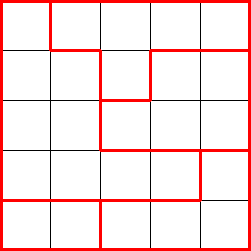

CPU times: total: 15.6 ms
Wall time: 45.4 ms


[]

In [14]:
%%time
solver("Exemples/test3.txt", 2, convert_to_3sat=True)

## And finally using the unsat grid :

## Starbattle Solver
#### The grid is UNSAT or UNDEF with (3610 clauses)


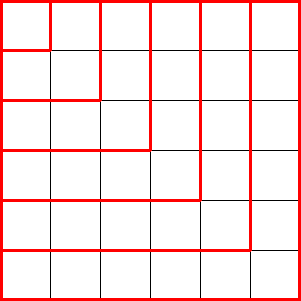

CPU times: total: 0 ns
Wall time: 55.6 ms


[]

In [15]:
%%time
solver("Exemples/test6.txt", 1)

## Some time testing comparing locat SAT solver with python-sat :

## Starbattle Solver
#### Solved grid (generated with 1264 clauses)


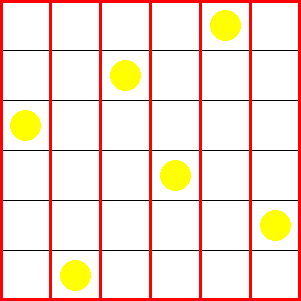

342 ms ± 115 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit -n 10
solver("Exemples/test5.txt", 1, local=True)

## Starbattle Solver
#### Solved grid (generated with 1264 clauses)


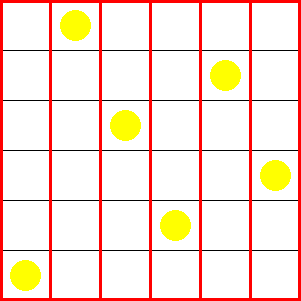

30.2 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit -n 10
solver("Exemples/test5.txt", 1)

The times seem to be comparable, but when moving to larger grids the local solver seems to be much slower, also for the case where there is no solution, the local solver does not guarantee that there is no solution and when there is not, it can run for a long time.